## VaR Backtesting on S&P500 Data

Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Reading the dataset .csv file and storing it into a pandas dataframe

In [ ]:
#Using pandas to import the dataset
df = pd.read_csv('Jan 24 Exam 1 Data.csv')
df.head()

,Date,SP500
0,22/01/2013,1492.5601
1,23/01/2013,1494.8101
2,24/01/2013,1494.8199
3,25/01/2013,1502.9600
4,28/01/2013,1500.1801


Dropping all null values

In [ ]:
#Dropping null values and creating necessary seperate lists from the Dataframe
df = df.dropna()
sp500 = df['SP500'].dropna()
returns = df['SP500'].pct_change().dropna()*100
print(returns.head())

1    0.1507
2    0.0007
3    0.5445
4   -0.1850
5    0.5106
Name: SP500, dtype: float64


Displaying the graph of Daily Returns of the S&P500 index

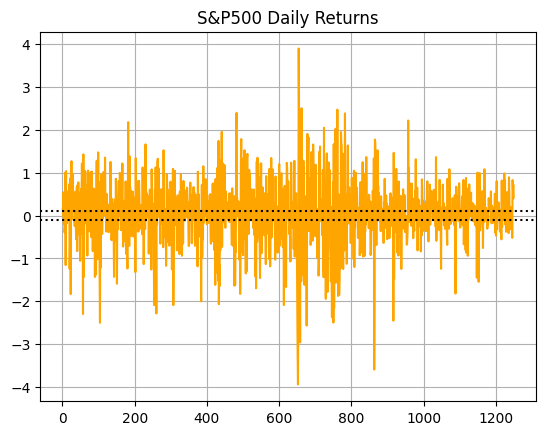

In [ ]:
plt.plot(returns, color='orange')
plt.axhline(y=0.10, ls='dotted', color='black')
plt.axhline(y=-0.10, ls='dotted', color='black')
plt.title('S&P500 Daily Returns')
plt.grid(True)

Calculating the Factor at 99% confidence

In [ ]:
Factor = norm.ppf(1-0.99)
print(Factor)

-2.3263478740408408


Calculating $VaR_{10D,t}$ using the given formula and storing it in a Dataframe<br>

$VaR_{10D,t} = Factor \times \sigma_{t} \times \sqrt{10}$

For this we calculate the rolling standard deviation over a 21 day window to find the volatility of the returns.

In [ ]:
#Declare an empty list to store values
var_list=[]
i = 1
j = 21
#We calculate rolling standard deviation over a 21 day window using a nestec while loop
while(i<=len(returns)-21):
    while(j<=len(returns)):
        std = np.std(returns[i:j])
        #Once we find the std, we calculate VaR for that volatility
        var = std*np.sqrt(10)*Factor
        #Store the VaR in the list
        var_list.append(var)
        i+=1
        j+=1 
print(len(var_list))
#Finally transfer it into a Dataframe
vr = pd.DataFrame(var_list, columns=['VaR']) 
print(vr.head())    

1229
      VaR
0 -4.3831
1 -4.5892
2 -5.4295
3 -5.5242
4 -5.8436


Here, to calculate the 10 Day forward returns, we take the **natural log(ln)** of the **ratio** of consecutive closing prices.
<br><br>

$r_{t} = ln\biggl(\frac{cp_{t}}{cp_{t-1}}\biggr)$
<br><br>

$cp_{t}$ = closing price at time $t$

$cp_{t-1}$ = closing price at time $t-1$
<br><br>

This is done because holds properties such as time-additivity over multiple periods.
<br><br>

For our calculations we are taking $ln\biggl(\frac{cp_{t+1}}{cp_{t+11}}\biggr)$

In [ ]:
#Declare an empty list to store return values
rets_list = []
i=22
j=32
#We use a nested while loop to calculate the natural log of the consecutive closing prices to get the 10 day forward returns
while(i<=1239):
    while(j<=1249):
        rets = np.log(sp500[j]/sp500[i])*100
        #Store the values in the list
        rets_list.append(rets)
        i+=1
        j+=1
print(len(rets_list))
#Transfer it into a Dataframe
rt = pd.DataFrame(rets_list, columns=['Returns'])
print(rt.head())

1218
   Returns
0   2.3205
1   4.4928
2   3.6431
3   2.5098
4   3.1550


To calculate the breaches in VaR, we check the following condition :<br>
If :

$r_{10D,t+10} < VaR_{10D,t}$

Then there a breach has occured and we return 1.
<br><br>

Finally we store all the breaches in a seperate Dataframe for easier plotting of graphs.
<br><br>

**Please Note :** We are comparing $VaR_{10D,t}$ to $r_{10D,t+10}$ calculated as $ln\biggl(\frac{S_{t+1}}{S_{t+11}}\biggr)$

In [ ]:
#Declare a list to store breach values
breach_list = []
#Using a for loop to iterate through all VaR and Returns values to check if the condition mentioned above is true
for i in range(0,1218):
    if(rt._get_value(i,'Returns')<vr._get_value(i,'VaR')):
        breach_list.append(1)
    else:
        breach_list.append(0)

breach = pd.DataFrame(breach_list, columns=['Breach'])
breach['VaR'] = vr['VaR']
breach['Date'] = df['Date'].iloc[0:1218]
#Finally storing all breach values along with the respective VaR and Dates in a Dataframe
databreach = breach.loc[breach['Breach']==1]
print(databreach.head())

     Breach     VaR        Date
113       1 -3.3638  03/07/2013
119       1 -2.9902  12/07/2013
120       1 -2.9403  15/07/2013
228       1 -4.4793  16/12/2013
229       1 -3.7968  17/12/2013


#### (a) Count and Percentage of VaR Breaches

In [ ]:
count= databreach['Breach'].count()
print('Number of Breaches :',count)
print('Percentage of Breaches :', np.around((count/1218)*100,4),'%')

Number of Breaches : 28
Percentage of Breaches : 2.2989 %


#### (b) Count and Percentage of Consecutive VaR Breaches

In [ ]:
consec = 0
for j in range(0,1217):
    if((breach._get_value(j, 'Breach')== 1) and (breach._get_value(j, 'Breach')==breach._get_value(j+1, 'Breach'))):
        consec+=1
print('Number of consecutive breaches :',consec)
print('Percentages of consecutive breaches :',np.around((consec/count)*100,4),'%')


Number of consecutive breaches : 16
Percentages of consecutive breaches : 57.1429 %


#### (c) Visual Representation of VaR and Breaches along with the Levels of the Index

In [ ]:
#Declare 2 subplots for VaR and S&P500 values
fig = make_subplots(rows =2, cols =1, shared_xaxes=True, vertical_spacing=0.05, subplot_titles=('Backtesting of VaR', 'S&P500'))

#Plotting the calculated VaR values at 99%/10D and 10 day forward Returns
fig.add_trace(go.Scatter(x = df['Date'],  y = vr['VaR'], mode = 'lines', name = 'VaR 99%/10Day', 
                         line = dict(color='red',width=0.5)), row=1,col=1)
fig.add_trace(go.Scatter(x = df['Date'],  y = rt['Returns'], mode = 'lines', name = '10Day Fwd Returns', 
                         line = dict(color='green',width=0.5)), row=1,col=1)

#Marking the Breach points with 'x' markers
fig.add_trace(go.Scatter(x = databreach['Date'], y=databreach['VaR'], mode='markers', name='Breach', 
                         marker=dict(color='black',size=10, line=dict(width=1,color='yellow'),symbol='x')),row=1,col=1)

#Plotting the S&P500 values
fig.add_trace(go.Scatter(x = df['Date'],  y = df['SP500'], mode = 'lines', name = 'Index Level', 
                         line = dict(color='blue',width=0.5)), row=2,col=1)

#Adjusting size and titles of the graphs
fig.update_layout(height=1000, width=1350, title_text='VaR Backtesting and S&P500', showlegend=True)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Value',row=1,col=1)
fig.update_yaxes(title_text='Index Level',row=2,col=1)

#Display the graphs
py.iplot(fig)


In the graph below, the 'x' denotes all the points where the Returns, $r_{10D,t+10}$ is lesser than $VaR_{10D,t}$.<br>
This means those points on the graph were falling below the maximum loss at 99%/10Day, which is also known as a VaR Breach.<br><br>
The graph also points out consecutive breaches in VaR which shows that the returns were in negatives for a consecutive number of days.
